# A note on Causal Mediation Analysis on Navy CHARM

In [1]:
library('mediation')
library('LSD')
library('lme4')
library('tidyverse')

setwd('/mnt/home/zzhang/ceph/jemm')
theme_set(theme_bw(base_size = 12))
options(repr.plot.width=9, repr.plot.height=9)

myTheme = ggplot2::theme(
                legend.text = ggplot2::element_text(size = 13),
                plot.title = ggplot2::element_text(size=13, face="bold"),
                axis.title.y = ggplot2::element_text(size=13),
                axis.title.x = ggplot2::element_text(size=13),
                axis.text.y = ggplot2::element_text(size=13),
                axis.text.x = ggplot2::element_text(size=13),
                legend.background = ggplot2::element_rect(fill = "transparent", colour = "transparent"))

Loading required package: MASS

Loading required package: Matrix

Loading required package: mvtnorm

Loading required package: sandwich

mediation: Causal Mediation Analysis
Version: 4.5.0


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ dplyr::select() masks MASS::select()
✖ tidyr::unpack() masks Matrix::unpack()



# Read data and PCA

In [2]:
# read in data
symp_df = read.table('data-V9/mediation_analysis/first_mid.forCMA.txt', header=T, sep="\t")
symp_df[,'viral_load'] = 40 - symp_df['CTavg']

SIGNIF_CUTOFF = 1
N_SIMS = 2000
#N_PCS = 5

tot_res = NULL

In [3]:
# re-define symptomatic
sub.symps = c('abd', 'chill', 'cough', 'diarr', 'fatigue', 'fvr', 'headache',
    'msk', 'nv', 'rn_nose', 'sob', 'subj_fvr', 'taste', 'throat')
# DO NOT RUN - IS IDENTICAL
#plot(as.numeric(apply(symp_df[, sub.symps], 1, sum)), symp_df$num_symps)
#symp_df['num_symps'] = as.numeric(apply(symp_df[, sub.symps], 1, sum))

# Utils funcs

In [4]:
make_plot_tibble = function(model, med_outs){
  med_out = med_outs[[model]]
  med_var = strsplit(this$model[1], "\\.")[[1]] %>% tail(n=1)
  tibble(mediator = med_var,
   effect = c("ACME", "ADE", "Total effect", "Prop. Mediated") ,
   estimate = c(med_out$d0, med_out$z0, med_out$tau.coef, med_out$n.avg),
   conf_lower = c(med_out$d0.ci[1], med_out$z0.ci[1], med_out$tau.ci[1], med_out$n.avg.ci[1]),
   conf_upper = c(med_out$d0.ci[2], med_out$z0.ci[2], med_out$tau.ci[2], med_out$n.avg.ci[2]))
}

vis_med_out = function(this, med_outs) {
    tibble(
        variable=this$model,
    ) %>% mutate(results = map(this$model, make_plot_tibble, med_outs)) %>%
    unnest(cols=c(results)) %>% 
    ggplot(aes(variable, estimate, ymin = conf_lower, ymax = conf_upper)) + 
      facet_wrap(~ effect, scales = "free_x") + 
      geom_pointrange() + 
      coord_flip() + 
      labs(y = "Estimate", x = "") +
      geom_hline(yintercept=0, linetype='dashed', color="black") + myTheme
}

rbind.tibble.to_res = function(tibble_res, tot_res) {

    this = tibble_res %>% select(-data) %>%
      unnest(c(results)) 
    pvals = this %>% 
      pivot_wider(mediator, names_from="effect", values_from="pvals") %>%
      filter(ACME<SIGNIF_CUTOFF)

    est = this %>% 
      pivot_wider(mediator, names_from="effect", values_from="estimate") %>%
      filter(mediator %in% pvals$mediator)

    model = pvals$mediator
    add = data.frame(
       model=model,
       acme=est$ACME,
       acme.p=pvals$ACME,
       prop = est$'Prop. Mediated',
       prop.p = pvals$'Prop. Mediated'
    )
    print(add)
    tot_res = rbind.data.frame(tot_res, add, stringsAsFactors=F)
    tot_res
}

# 1. Mediation to viral load [BASELINE --> INITIAL INFECT (w/ or w/o RNA-seq)]

In [5]:
first_data = symp_df[symp_df$final=="First", ]
mid_data = symp_df[symp_df$final=="Mid", ]

#mediators = paste('PC', seq(1,N_PCS), sep='')

In [6]:
mediators = c(
    'base_ISG_LV3',
    'base_ISG_LV5',
    'base_ISG_LV6',
    'base_ISG_LV10'
    #'base_CELL.Neutrophil.3',
    #'base_CELL.Neutrophil.2',
    #'base_CELL.Neutrophil.1' # for V7
    #'base_CELL..Neutrophil' # for V9
)

In [7]:
datasets = list(first=first_data[!is.na(first_data$base_ISG_LV3_prj),])
datasets$first %>% distinct(pid, Sex) %>% count(Sex)

Sex,n
<fct>,<int>
F,25
M,193


In [8]:
#print(mediators)

outcome = c('viral_load')
treatment = c('is_female')

set.seed(123)
x.ct = mediations(datasets, treatment, mediators, outcome,
        families=c('gaussian', 'gaussian'),
        conf.level=0.9,
        sims=N_SIMS,
        boots=T
)

res.ct = NULL
for(i in 1:length(x.ct)) {
        this = summary(x.ct[[names(x.ct)[i]]])
        res.ct = rbind.data.frame(res.ct,
                list(
                        model = names(x.ct)[i],
                        acme = this$d.avg,
                        acme.p = this$d.avg.p,
                        prop = this$n0,
                        prop.p = this$n0.p
                ),
        stringsAsFactors=F
        )
}
#res.ct$acme.fdr = p.adjust(res.ct$acme.p, method='fdr')
print(res.ct[res.ct$acme.p<SIGNIF_CUTOFF,])
tot_res = rbind.data.frame(tot_res, res.ct[res.ct$acme.p<SIGNIF_CUTOFF,], stringsAsFactors=F)

                               model         acme acme.p         prop prop.p
1  viral_load.is_female.base_ISG_LV3 -0.227922099  0.725 0.0749243742  0.733
2  viral_load.is_female.base_ISG_LV5 -0.004250589  0.994 0.0002058021  0.989
3  viral_load.is_female.base_ISG_LV6 -0.480633690  0.088 0.1693199485  0.119
4 viral_load.is_female.base_ISG_LV10 -0.278744798  0.295 0.0907306067  0.324


In [9]:
# vis
res.ct

,model,acme,acme.p,prop,prop.p
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,viral_load.is_female.base_ISG_LV3,-0.227922099,0.725,0.0749243742,0.733
2,viral_load.is_female.base_ISG_LV5,-0.004250589,0.994,0.0002058021,0.989
3,viral_load.is_female.base_ISG_LV6,-0.480633690,0.088,0.1693199485,0.119
4,viral_load.is_female.base_ISG_LV10,-0.278744798,0.295,0.0907306067,0.324


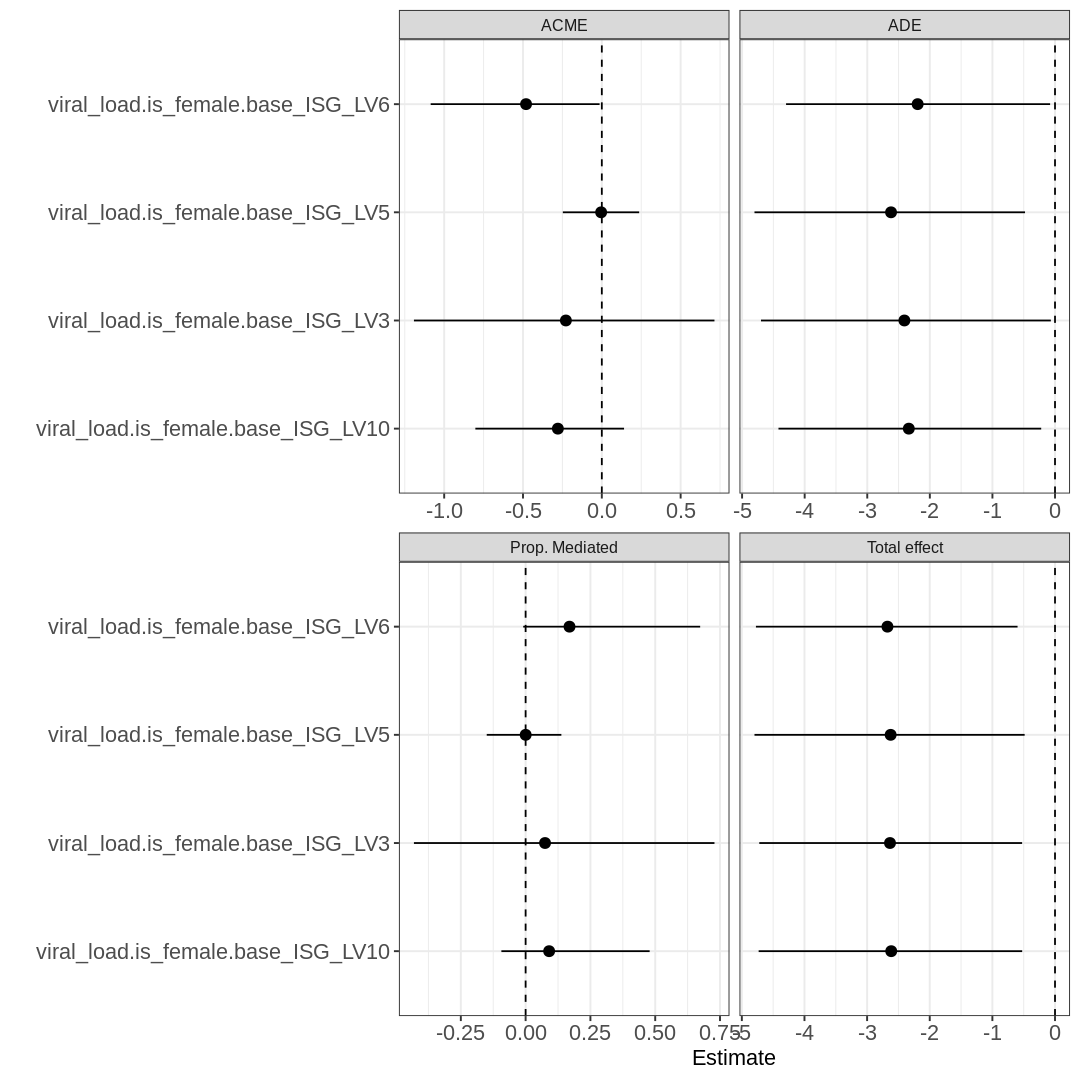

In [10]:
# vis for ct
this = res.ct[res.ct$acme.p<SIGNIF_CUTOFF,]
if(nrow(this)>0) vis_med_out(res.ct, x.ct)

# 2. Mediation for Number of Symptoms [BASELINE TO INITIAL PCR positive (w/ or w/o RNA-seq]

In [11]:
first_data[(!is.na(first_data$base_ISG_LV3_prj)) & (!is.na(first_data$num_symps)),] %>% distinct(pid, Sex) %>% count(Sex)


Sex,n
<fct>,<int>
F,25
M,193


In [12]:
poisson_med_func <- function(data, med_var, n_sim = N_SIMS, ...) { 
  out_fit <- glm(num_symps ~ value + is_female, data = data, family='poisson')
  med_fit <- lm(value ~ is_female, data = data)
  med_out <- mediate(med_fit, out_fit, sims = n_sim,
                     treat = "is_female",
                     mediator = "value",
                     conf.level=0.9,
                     boots=T,
                     ...)
  tibble(mediator = paste('Num_Symps', 'is_female', med_var, sep="."),
       effect = c("ACME", "ADE", "Total effect", "Prop. Mediated") ,
       estimate = c(med_out$d0, med_out$z0, med_out$tau.coef, med_out$n.avg),
       conf_lower = c(med_out$d0.ci[1], med_out$z0.ci[1], med_out$tau.ci[1], med_out$n.avg.ci[1]),
       conf_upper = c(med_out$d0.ci[2], med_out$z0.ci[2], med_out$tau.ci[2], med_out$n.avg.ci[2]),
       pvals = c(med_out$d0.p, med_out$z0.p, med_out$tau.p, med_out$n.avg.p)
    )
}

# ---------- #
set.seed(123)
pois_med_res <- first_data %>%
  pivot_longer(all_of(mediators), names_to = "variable", values_to = "value") %>% 
  group_by(variable) %>% 
  nest() %>%
  mutate(results = map(data, poisson_med_func, variable, n_sim = N_SIMS))

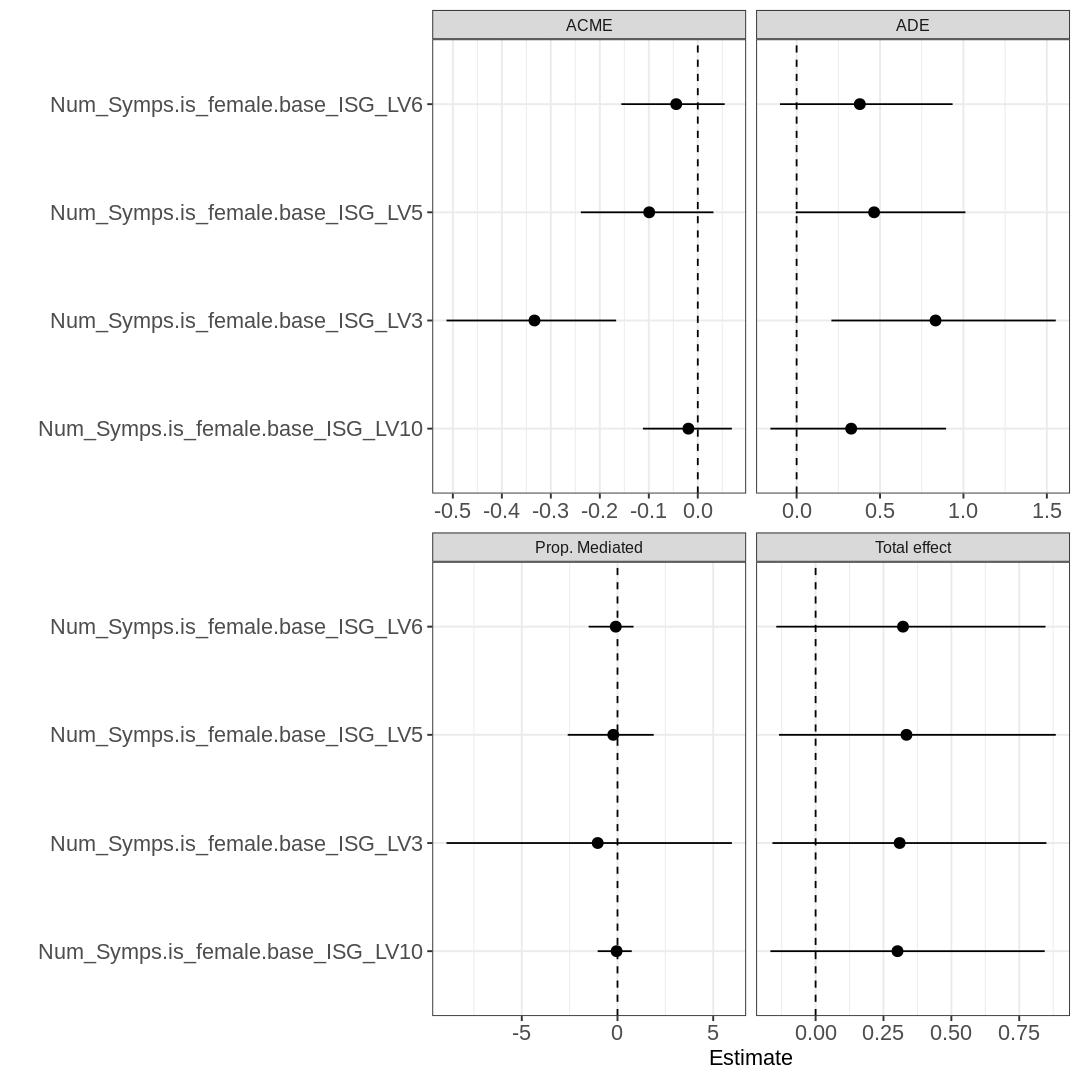

In [13]:
pois_med_res %>% select(-data) %>%
  unnest(c(results)) %>% 
  ggplot(aes(mediator, estimate, ymin = conf_lower, ymax = conf_upper)) + 
  facet_wrap(~ effect, scales = "free_x") + 
  geom_pointrange() + 
  coord_flip() + 
  labs(y = "Estimate", x = "") + 
  geom_hline(yintercept=0, linetype='dashed', color="black") + myTheme

In [14]:
this = pois_med_res %>% select(-data) %>%
  unnest(c(results)) 
pvals = this %>% 
  pivot_wider(mediator, names_from="effect", values_from="pvals") %>%
  filter(ACME<SIGNIF_CUTOFF)

est = this %>% 
  pivot_wider(mediator, names_from="effect", values_from="estimate") %>%
  filter(mediator %in% pvals$mediator)

model = pvals$mediator
add = data.frame(
   model=model,
   acme=est$ACME,
   acme.p=pvals$ACME,
   prop = est$'Prop. Mediated',
   prop.p = pvals$'Prop. Mediated'
)
tot_res = rbind.data.frame(tot_res, add, stringsAsFactors=F)

In [15]:
add

model,acme,acme.p,prop,prop.p
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Num_Symps.is_female.base_ISG_LV3,-0.33337816,0.001,-1.03419718,0.295
Num_Symps.is_female.base_ISG_LV5,-0.09917458,0.206,-0.21972292,0.460
Num_Symps.is_female.base_ISG_LV6,-0.04401803,0.460,-0.08983398,0.630
Num_Symps.is_female.base_ISG_LV10,-0.01915131,0.679,-0.04751042,0.759


# 3. Mediation for Infection ISGs [BASELINE --> INFECT RNA-seq]

In [16]:
symp_df[(!is.na(symp_df[,'base_ISG_LV3_prj'])) & (!is.na(symp_df[,'ISG_LV3_prj'])),] %>% distinct(pid, Sex) %>% count(Sex)


Sex,n
<fct>,<int>
F,17
M,163


                                model          acme acme.p          prop prop.p
1  ISG_LV3_prj.is_female.base_ISG_LV3  0.1168826026  0.000  0.6782947873  0.015
2  ISG_LV3_prj.is_female.base_ISG_LV5 -0.0004088142  0.985 -0.0008185814  0.989
3  ISG_LV3_prj.is_female.base_ISG_LV6 -0.0027192521  0.839 -0.0160493406  0.844
4 ISG_LV3_prj.is_female.base_ISG_LV10 -0.0176957935  0.286 -0.1002386715  0.292


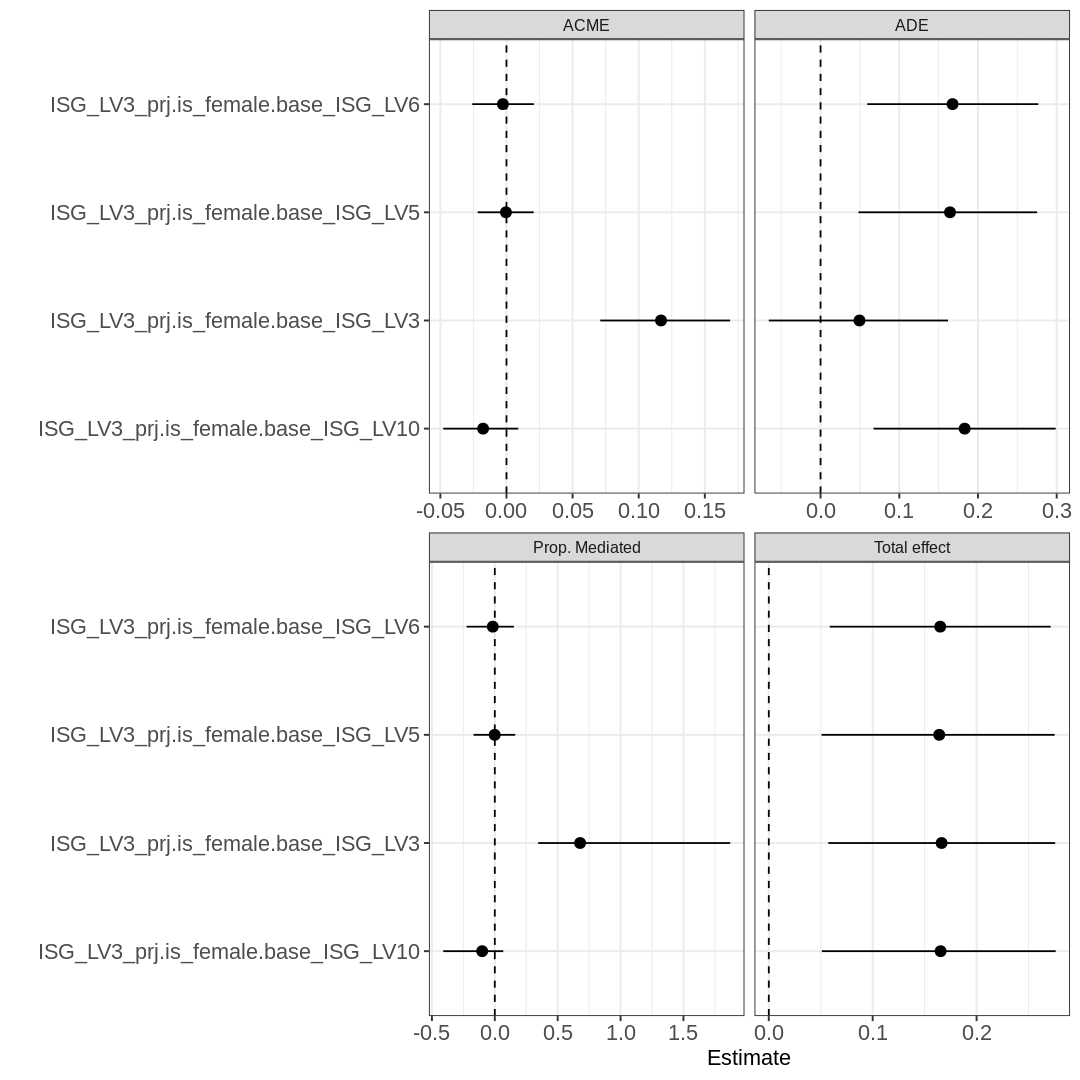

                                model         acme acme.p      prop prop.p
1  ISG_LV5_prj.is_female.base_ISG_LV3 -0.005592600  0.630 0.1057781  0.847
2  ISG_LV5_prj.is_female.base_ISG_LV5 -0.039486838  0.001 1.1556815  0.568
3  ISG_LV5_prj.is_female.base_ISG_LV6 -0.006034236  0.288 0.1156605  0.693
4 ISG_LV5_prj.is_female.base_ISG_LV10 -0.019339652  0.003 0.4675728  0.598


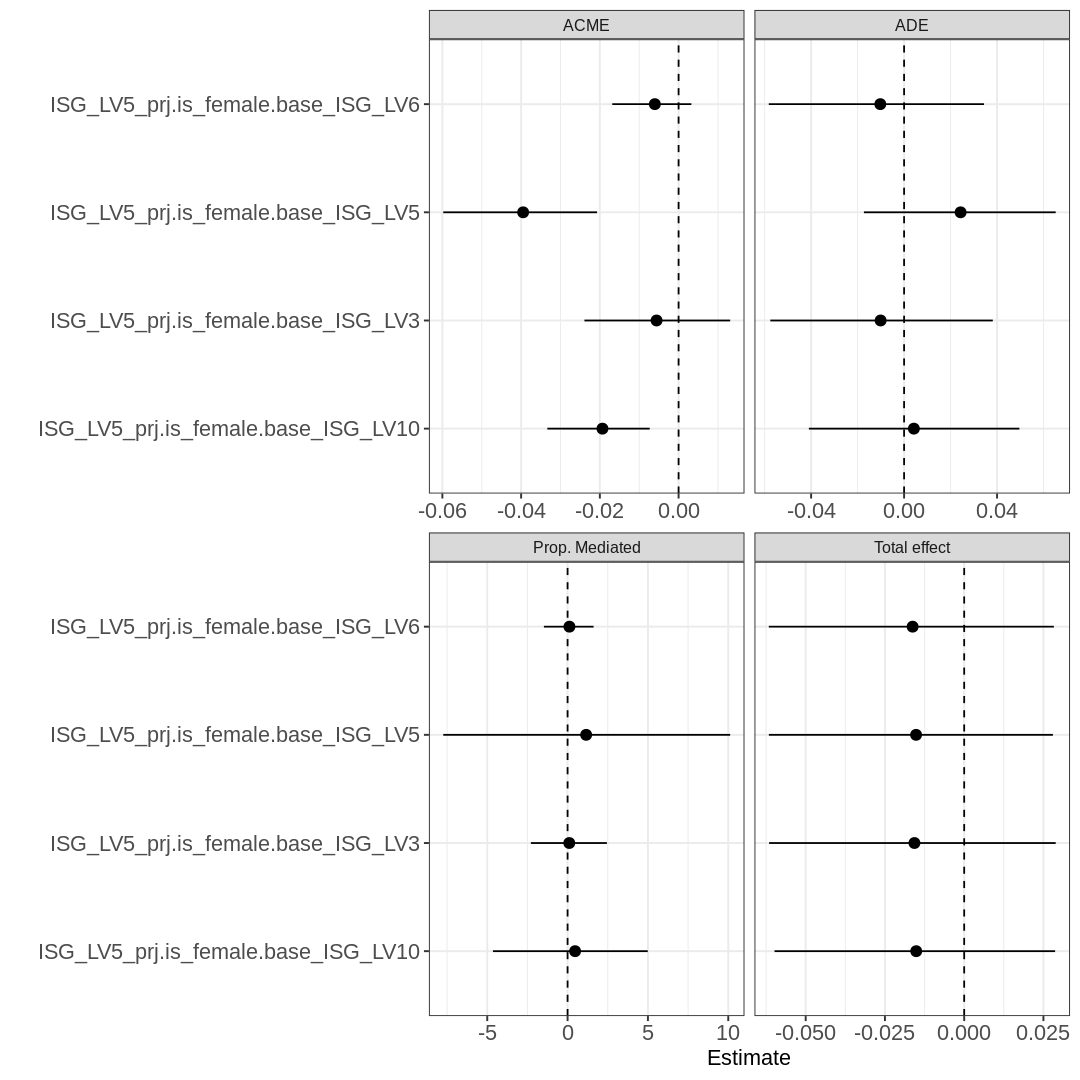

                                model         acme acme.p        prop prop.p
1  ISG_LV6_prj.is_female.base_ISG_LV3 -0.032656305  0.374 -0.17035398  0.416
2  ISG_LV6_prj.is_female.base_ISG_LV5 -0.007583692  0.656 -0.03658779  0.684
3  ISG_LV6_prj.is_female.base_ISG_LV6 -0.015679041  0.407 -0.08494691  0.444
4 ISG_LV6_prj.is_female.base_ISG_LV10 -0.013108718  0.556 -0.07099527  0.579


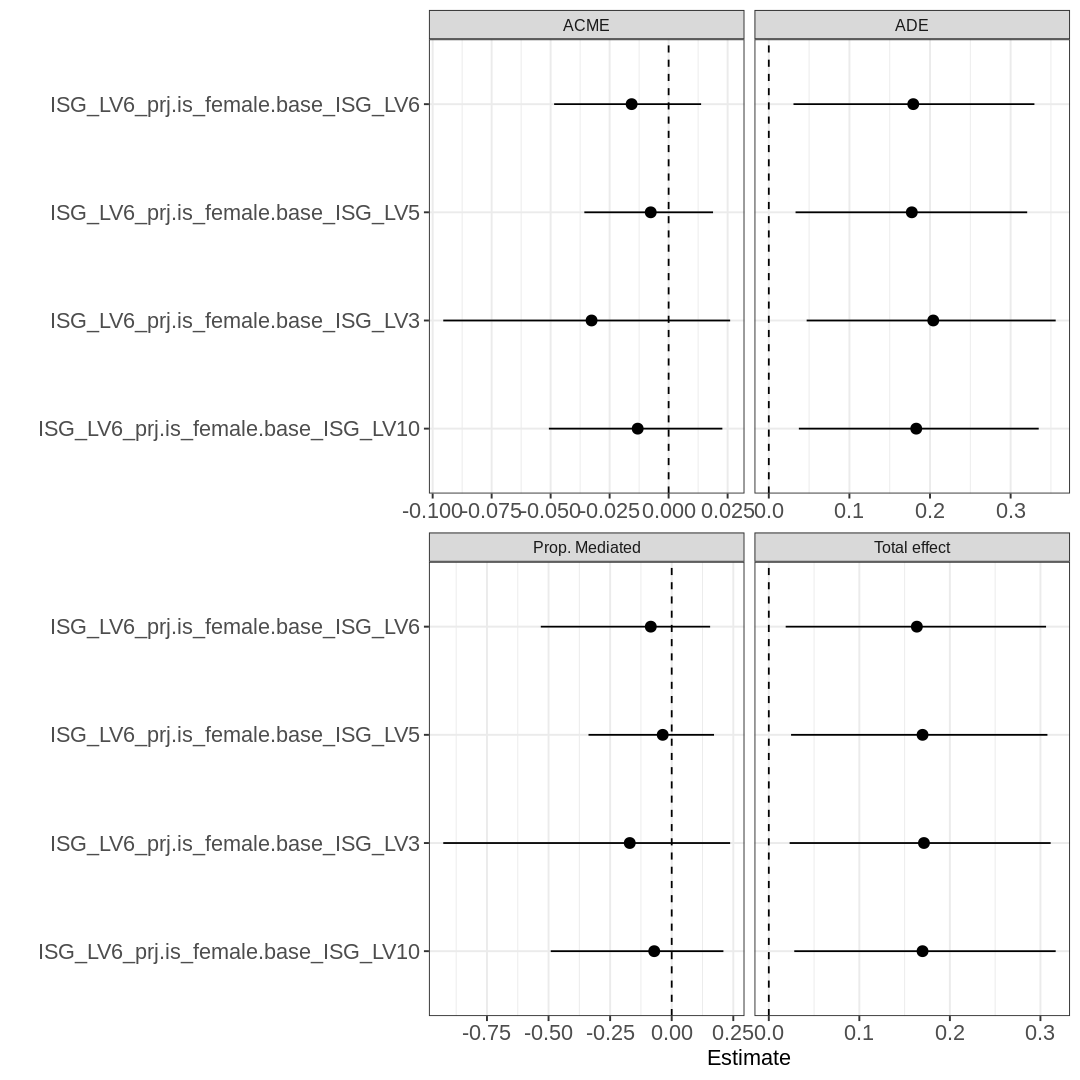

                                 model         acme acme.p        prop prop.p
1  ISG_LV10_prj.is_female.base_ISG_LV3 -0.017189130  0.566 -0.13035950  0.651
2  ISG_LV10_prj.is_female.base_ISG_LV5 -0.004949663  0.729 -0.03492918  0.772
3  ISG_LV10_prj.is_female.base_ISG_LV6 -0.026977104  0.070 -0.20005242  0.220
4 ISG_LV10_prj.is_female.base_ISG_LV10 -0.004898299  0.796 -0.03347979  0.829


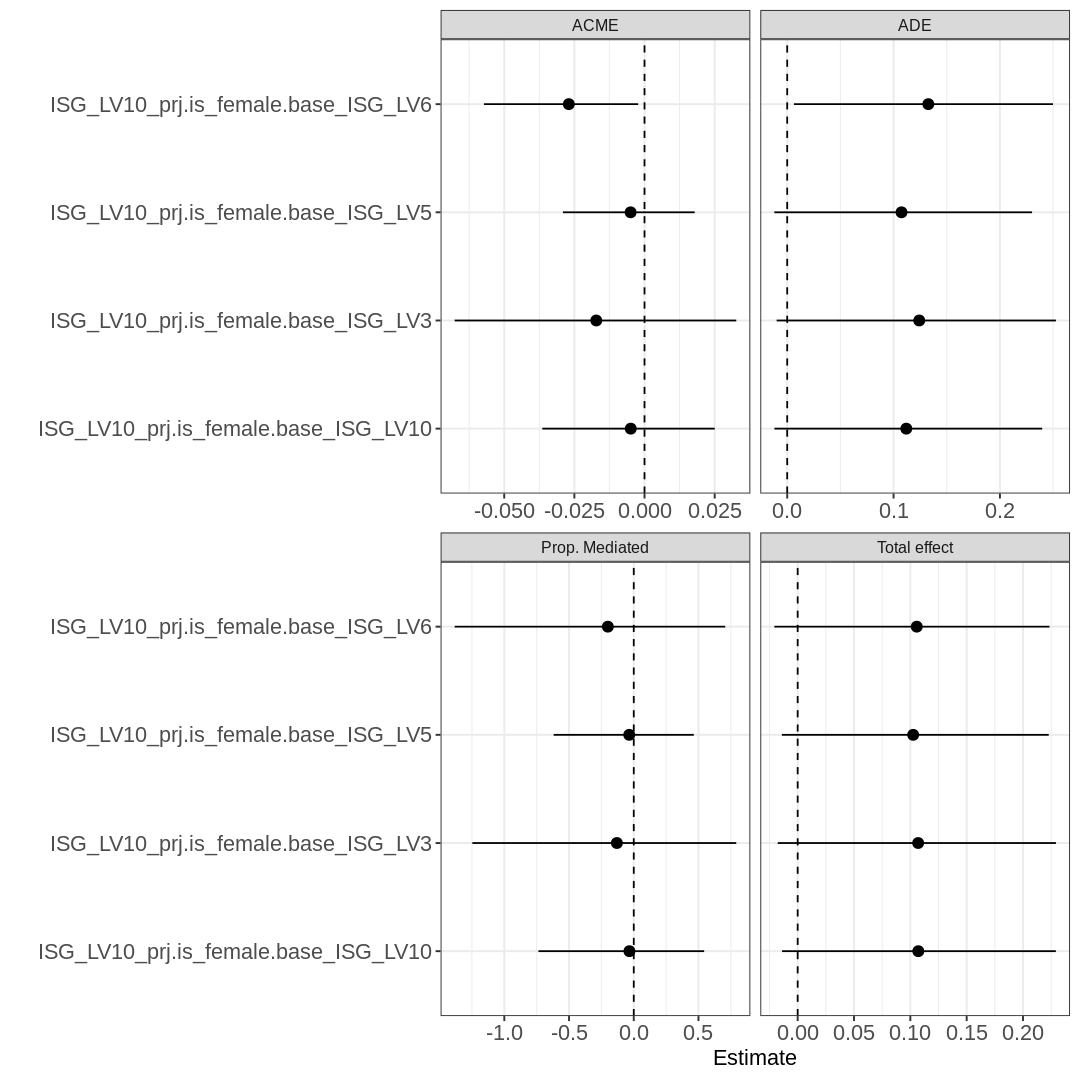

In [17]:
lmer_med_func2 = function(data, med_var, out_var, n_sim = N_SIMS, ...) { 
  if(length(grep('base_', med_var))) {
      # baseline ISG serves as a random intercept
      out_fit = lm(out_val ~ med_val + days_since_infect + is_female, data = data)
      med_fit = lm(med_val ~ is_female + days_since_infect, data = data)
  } else {
      out_fit = lmer(out_val ~ med_val + days_since_infect + is_female + (1|pid), data = data)
      med_fit = lmer(med_val ~ is_female + days_since_infect + (1|pid), data = data)
  }
  med_out = mediate(med_fit, out_fit, sims = n_sim,
                     treat = "is_female",
                     mediator = "med_val",
                     conf.level=0.9,
                     boots=T,
                     dropobs=T,
                     ...)
  tibble(mediator = paste(out_var, 'is_female', med_var, sep="."),
       effect = c("ACME", "ADE", "Total effect", "Prop. Mediated") ,
       estimate = c(med_out$d0, med_out$z0, med_out$tau.coef, med_out$n.avg),
       conf_lower = c(med_out$d0.ci[1], med_out$z0.ci[1], med_out$tau.ci[1], med_out$n.avg.ci[1]),
       conf_upper = c(med_out$d0.ci[2], med_out$z0.ci[2], med_out$tau.ci[2], med_out$n.avg.ci[2]),
       pvals = c(med_out$d0.p, med_out$z0.p, med_out$tau.p, med_out$n.avg.p)
    )
}

# ---------- #
set.seed(777)
this_mediators = c(#'viral_load', 
                   mediators # also add baseline ISG LVs
)
outcome = c('ISG_LV3_prj', 'ISG_LV5_prj', 'ISG_LV6_prj', 'ISG_LV10_prj')

for(i in 1:length(outcome)) {
    out_var = outcome[i]
    out_df = symp_df[!is.na(symp_df[,out_var]),]
    out_val = out_df[, out_var]
    lmer_med_res2 <- out_df %>%
      pivot_longer(all_of(this_mediators), names_to = "variable", values_to = "med_val") %>% 
      group_by(variable) %>% 
      nest() %>%
      mutate(results = map(data, lmer_med_func2, variable, n_sim = N_SIMS, out_var=out_var, out_val=out_val))

    g = lmer_med_res2 %>% select(-data) %>%
      unnest(c(results)) %>% 
      ggplot(aes(mediator, estimate, ymin = conf_lower, ymax = conf_upper)) + 
      facet_wrap(~ effect, scales = "free_x") + 
      geom_pointrange() + 
      coord_flip() + 
      labs(y = "Estimate", x = "") + 
      geom_hline(yintercept=0, linetype='dashed', color="black") + myTheme
    plot(g)
    
    tot_res = rbind.tibble.to_res(lmer_med_res2, tot_res)
}

# 4. Mediation for PSI.CD45 [BASELINE --> INFECT RNA-seq]

In [18]:
datasets = list(data=symp_df[!is.na(symp_df[,'delta_PSI_CD45RBC']),])

# pid=1344 had non-defined PSI
datasets$data %>% distinct(pid, Sex) %>% count(Sex)

Sex,n
<fct>,<int>
F,17
M,162


In [19]:
outcome = c('delta_PSI_CD45RBC')
treatment = c('is_female')

set.seed(777)
x.psi = mediations(datasets, treatment, mediators, outcome,
        families=c('gaussian', 'gaussian'),
        conf.level=0.9,
        sims=N_SIMS
)

res.psi = NULL
for(i in 1:length(x.psi)) {
        this = summary(x.psi[[names(x.psi)[i]]])
        res.psi = rbind.data.frame(res.psi,
                list(
                        model = names(x.psi)[i],
                        acme = this$d.avg,
                        acme.p = this$d.avg.p,
                        prop = this$n0,
                        prop.p = this$n0.p
                ),
        stringsAsFactors=F
        )
}

#res.psi$acme.fdr = p.adjust(res.psi$acme.p, method='fdr')
print(res.psi[res.psi$acme.p<SIGNIF_CUTOFF,])
tot_res = rbind.data.frame(tot_res, res.psi[res.psi$acme.p<SIGNIF_CUTOFF,], stringsAsFactors=F)

                                      model         acme acme.p        prop
1  delta_PSI_CD45RBC.is_female.base_ISG_LV3  0.036613629  0.000  0.53462877
2  delta_PSI_CD45RBC.is_female.base_ISG_LV5 -0.009967351  0.006 -0.13835297
3  delta_PSI_CD45RBC.is_female.base_ISG_LV6  0.008786877  0.029  0.12514516
4 delta_PSI_CD45RBC.is_female.base_ISG_LV10 -0.002208711  0.658 -0.03002234
  prop.p
1  0.001
2  0.006
3  0.029
4  0.658


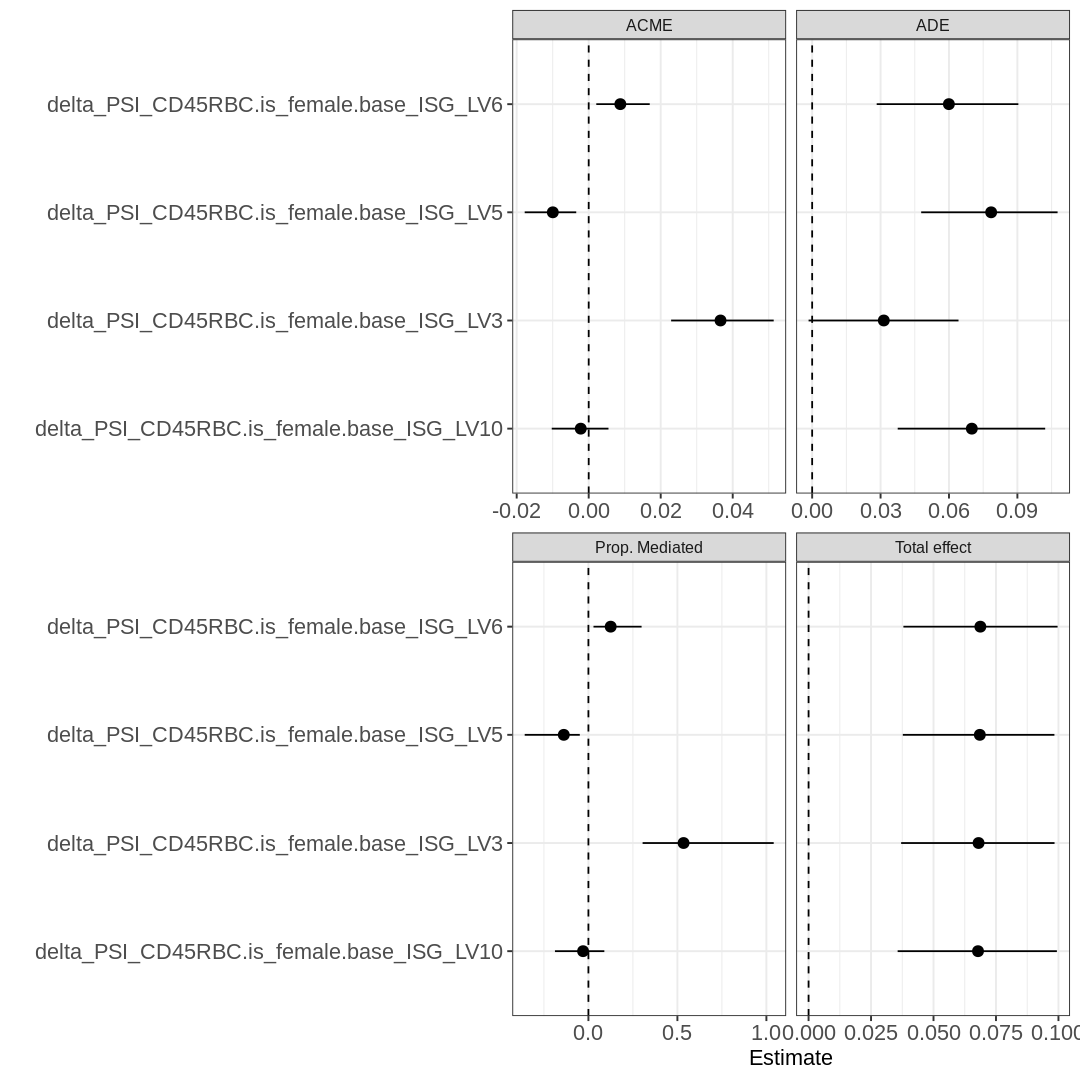

In [20]:
# vis results for cd45
this = res.psi[res.psi$acme.p<SIGNIF_CUTOFF,]
if(nrow(this)>0) vis_med_out(res.psi, x.psi)

# 5. Number of Symptoms over Time mediated by Infection ISGs [INFECT -> INFECT RNA-seq]

In [21]:
datasets = list(data=symp_df[!is.na(symp_df[,'ISG_LV3_prj']),])

datasets$data %>% distinct(pid, Sex) %>% count(Sex)

Sex,n
<fct>,<int>
F,34
M,188


                                      model        acme acme.p        prop
1  Num_Symps_overTime.is_female.ISG_LV3_prj  0.03308625  0.113  0.03870993
2  Num_Symps_overTime.is_female.ISG_LV5_prj -0.01360604  0.499 -0.01275353
3  Num_Symps_overTime.is_female.ISG_LV6_prj  0.14451313  0.000  0.18019810
4 Num_Symps_overTime.is_female.ISG_LV10_prj  0.16390305  0.000  0.20253570
  prop.p
1  0.113
2  0.499
3  0.000
4  0.000


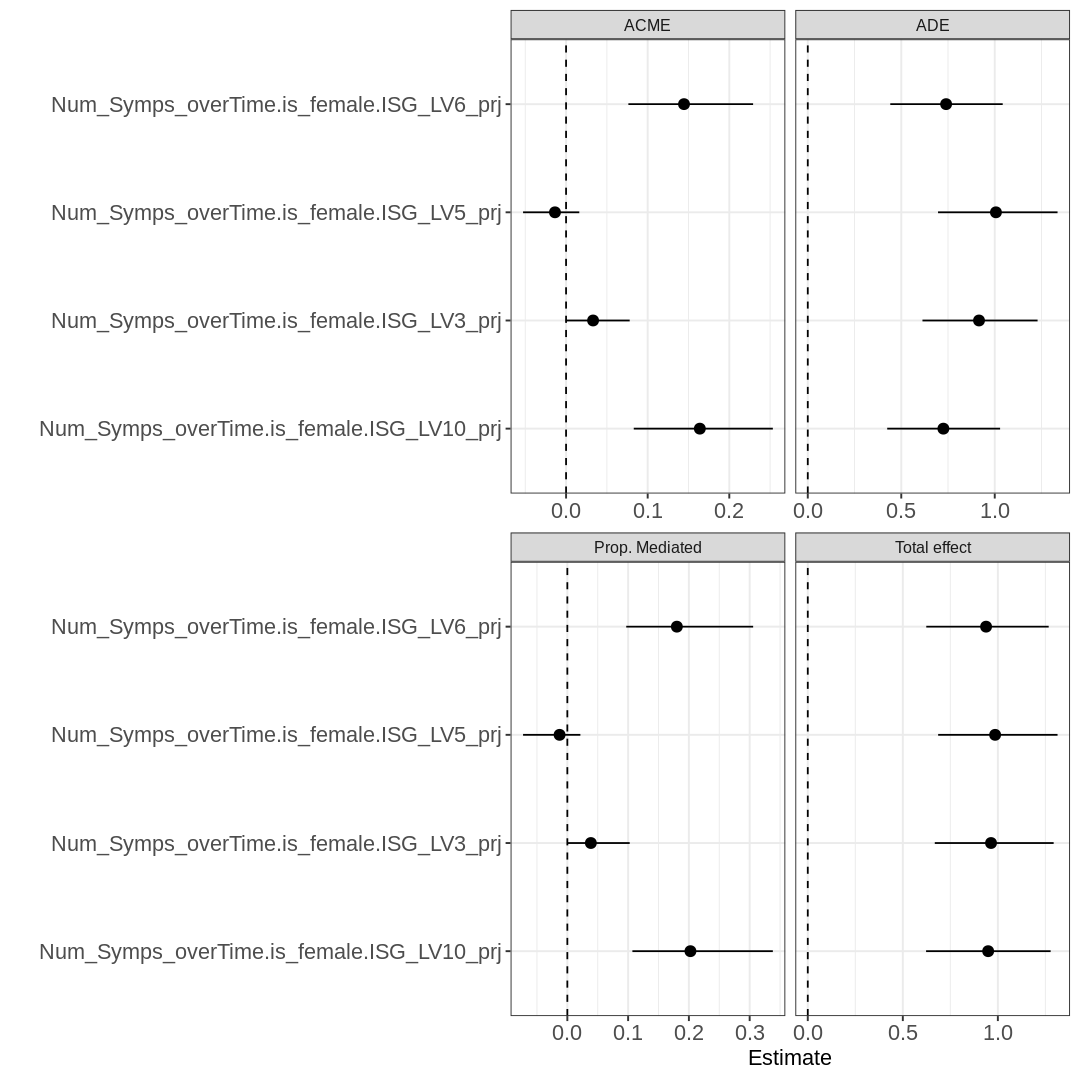

In [22]:
poisson_med_func2 <- function(data, med_var, n_sim = N_SIMS, ...) { 
  #out_fit <- glmer(num_symps ~ value + days_since_infect + is_female + (1|pid), data = data, family='poisson')
  out_fit <- glm(num_symps ~ value + days_since_infect + is_female, data = data, family='poisson')
  med_fit <- lmer(value ~ days_since_infect + is_female + (1|pid), data = data)
  med_out <- mediate(med_fit, out_fit, sims = n_sim,
                     treat = "is_female",
                     mediator = "value",
                     conf.level=0.9,
                     boots=F,
                     ...)
  tibble(mediator = paste('Num_Symps_overTime', 'is_female', med_var, sep="."),
       effect = c("ACME", "ADE", "Total effect", "Prop. Mediated") ,
       estimate = c(med_out$d0, med_out$z0, med_out$tau.coef, med_out$n.avg),
       conf_lower = c(med_out$d0.ci[1], med_out$z0.ci[1], med_out$tau.ci[1], med_out$n.avg.ci[1]),
       conf_upper = c(med_out$d0.ci[2], med_out$z0.ci[2], med_out$tau.ci[2], med_out$n.avg.ci[2]),
       pvals = c(med_out$d0.p, med_out$z0.p, med_out$tau.p, med_out$n.avg.p)
    )
}

# ---------- #
set.seed(111)
this_mediators = c('ISG_LV3_prj', 'ISG_LV5_prj', 'ISG_LV6_prj', 'ISG_LV10_prj')
pois_med_res2 <- symp_df %>%
  pivot_longer(all_of(this_mediators), names_to = "variable", values_to = "value") %>% 
  group_by(variable) %>% 
  nest() %>%
  mutate(results = map(data, poisson_med_func2, variable, n_sim = N_SIMS))

pois_med_res2 %>% select(-data) %>%
  unnest(c(results)) %>% 
  ggplot(aes(mediator, estimate, ymin = conf_lower, ymax = conf_upper)) + 
  facet_wrap(~ effect, scales = "free_x") + 
  geom_pointrange() + 
  coord_flip() + 
  labs(y = "Estimate", x = "") + 
  geom_hline(yintercept=0, linetype='dashed', color="black") + myTheme

tot_res = rbind.tibble.to_res(pois_med_res2, tot_res)

# Summary

In [23]:
tot_res

model,acme,acme.p,prop,prop.p
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
viral_load.is_female.base_ISG_LV3,-0.2279220986,0.725,0.0749243742,0.733
viral_load.is_female.base_ISG_LV5,-0.0042505888,0.994,0.0002058021,0.989
viral_load.is_female.base_ISG_LV6,-0.4806336896,0.088,0.1693199485,0.119
viral_load.is_female.base_ISG_LV10,-0.2787447976,0.295,0.0907306067,0.324
Num_Symps.is_female.base_ISG_LV3,-0.3333781613,0.001,-1.0341971775,0.295
Num_Symps.is_female.base_ISG_LV5,-0.0991745774,0.206,-0.2197229177,0.460
Num_Symps.is_female.base_ISG_LV6,-0.0440180335,0.460,-0.0898339846,0.630
Num_Symps.is_female.base_ISG_LV10,-0.0191513094,0.679,-0.0475104192,0.759
ISG_LV3_prj.is_female.base_ISG_LV3,0.1168826026,0.000,0.6782947873,0.015


In [24]:
write.table(tot_res, file="./data/mediation_analysis/out.cma.txt", quote=F, row.names=F, sep="\t")

# Misc

Warning message:
“Removed 741 rows containing missing values (geom_point).”


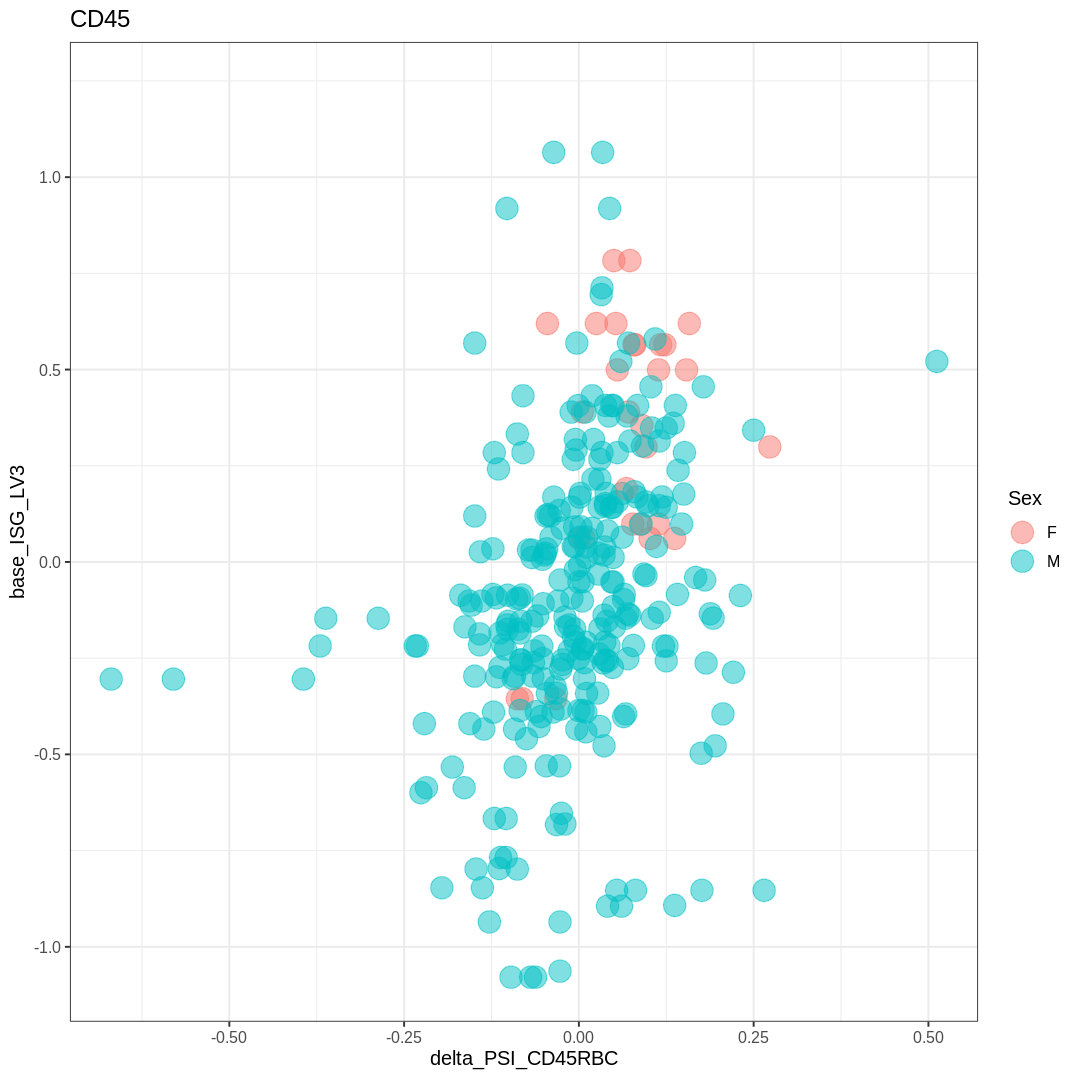

In [25]:
#plot(first_data$delta_PSI_CD45RBC, first_data$base_ISG_LV3, col=first_data$Sex)
ggplot(mid_data, aes(x=delta_PSI_CD45RBC, y=base_ISG_LV3, col=Sex)) + 
    geom_point(size=6, alpha=0.5) +
    ggtitle('CD45')


In [26]:
summary(glm(num_symps~is_female, data=first_data, family='poisson'))


Call:
glm(formula = num_symps ~ is_female, family = "poisson", data = first_data)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-2.087  -1.421  -1.421  -1.421   6.117  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) 0.009823   0.031264   0.314    0.753    
is_female   0.768719   0.067351  11.414   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 4278.8  on 1141  degrees of freedom
Residual deviance: 4167.2  on 1140  degrees of freedom
AIC: 5060.2

Number of Fisher Scoring iterations: 6


Warning message:
“Removed 929 rows containing missing values (geom_point).”


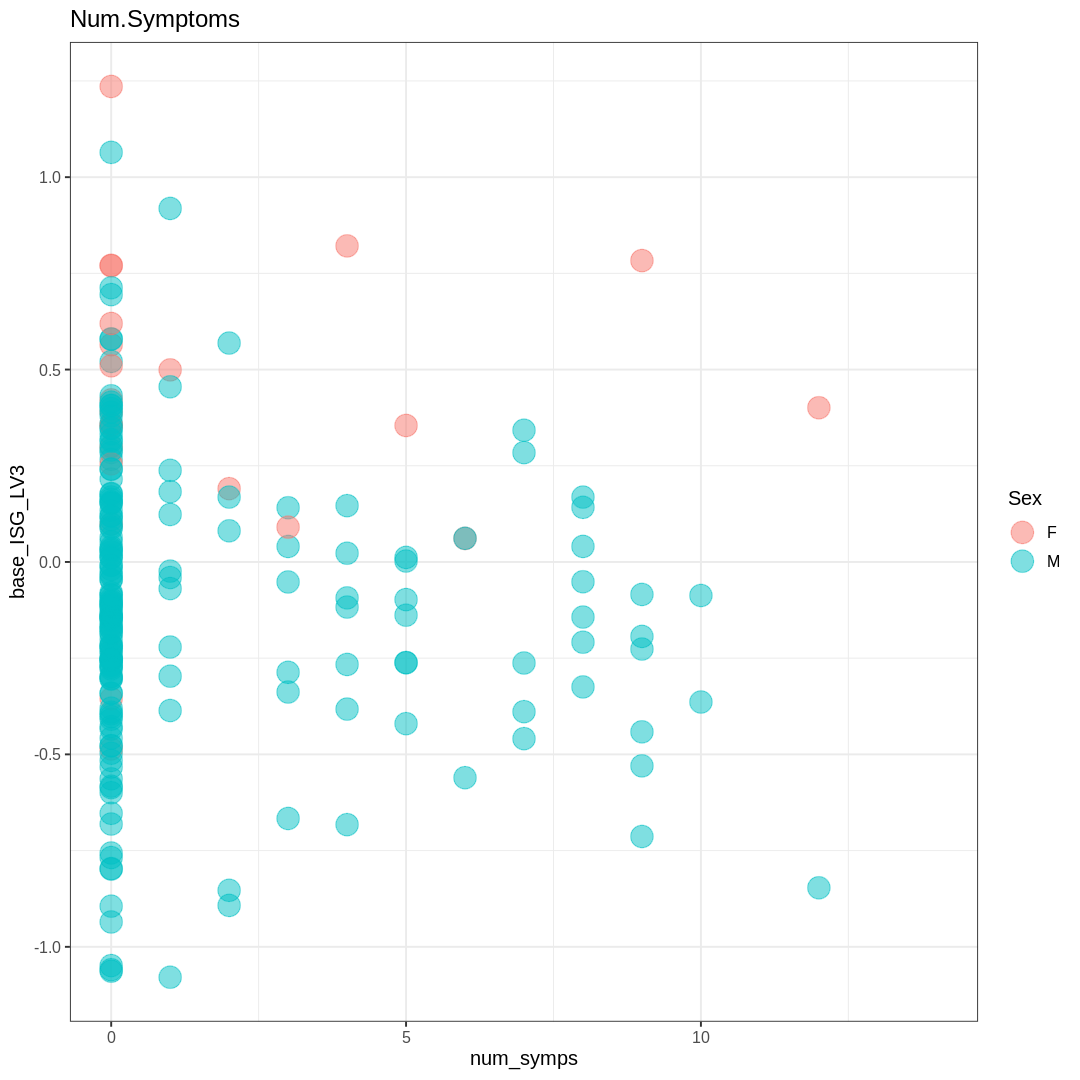

In [27]:
#plot(first_data$num_symps, first_data$base_ISG_LV3, col=first_data$Sex)
ggplot(first_data, aes(x=num_symps, y=base_ISG_LV3, col=Sex)) + 
    geom_point(size=6, alpha=0.5) +
    ggtitle('Num.Symptoms')

In [28]:
a = first_data %>% filter(Sex=="M")
b = first_data %>% filter(Sex=="F")
print(cor.test(a$base_ISG_LV3, a$num_symps))
print(cor.test(b$base_ISG_LV3, b$num_symps))


	Pearson's product-moment correlation

data:  a$base_ISG_LV3 and a$num_symps
t = -1.6992, df = 188, p-value = 0.09093
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.26077566  0.01971049
sample estimates:
       cor 
-0.1229879 


	Pearson's product-moment correlation

data:  b$base_ISG_LV3 and b$num_symps
t = 0.33432, df = 21, p-value = 0.7415
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3499356  0.4708424
sample estimates:
       cor 
0.07276209 



Warning message:
“Removed 1824 rows containing missing values (geom_point).”


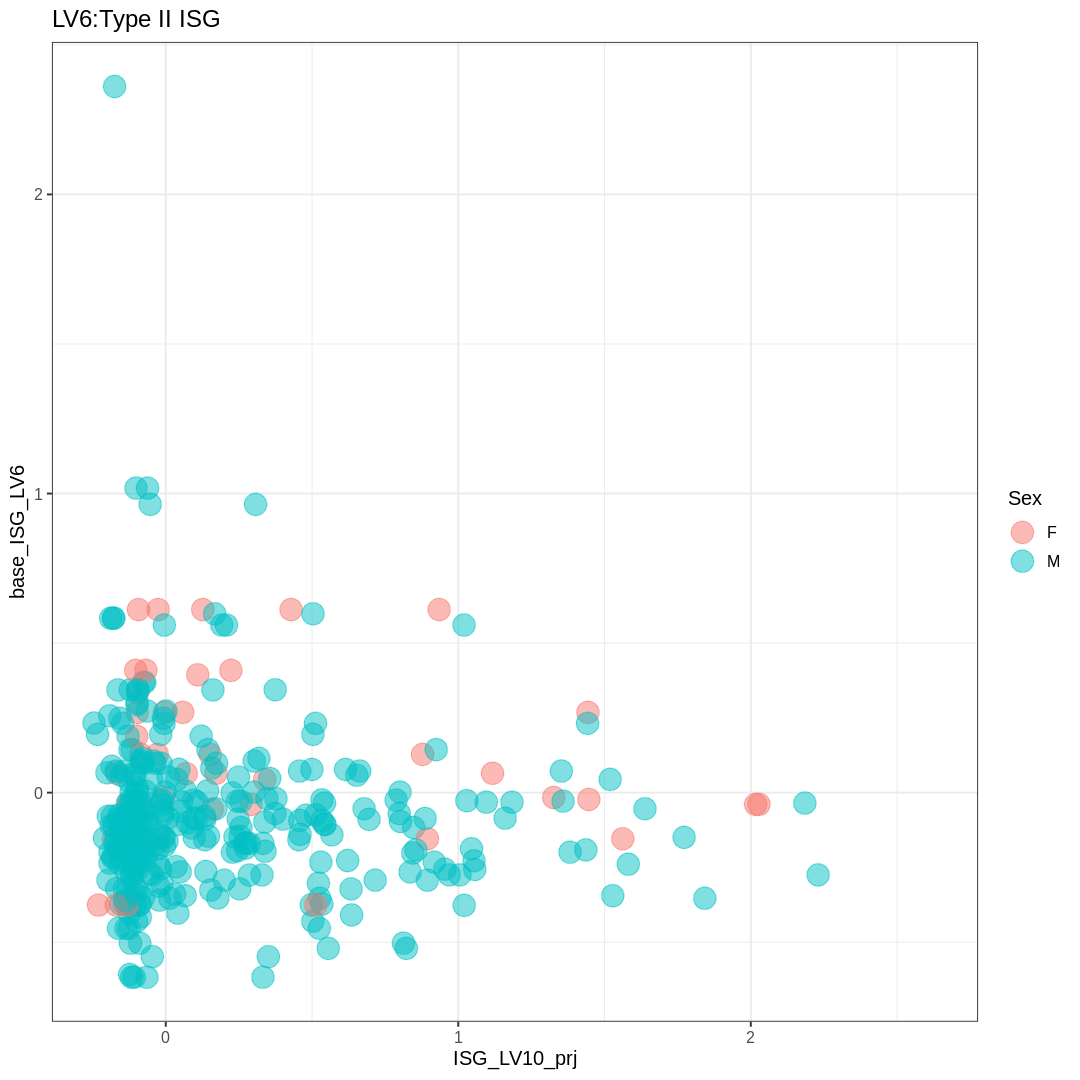

In [29]:
ggplot(symp_df, aes(x=ISG_LV10_prj, y=base_ISG_LV6, col=Sex)) + 
    geom_point(size=6, alpha=0.5) +
    ggtitle('LV6:Type II ISG')

In [30]:
a = symp_df %>% filter(Sex=="M")
b = symp_df %>% filter(Sex=="F")
print(cor.test(a$base_ISG_LV6, a$ISG_LV10_prj))
print(cor.test(b$base_ISG_LV6, b$ISG_LV10_prj))


	Pearson's product-moment correlation

data:  a$base_ISG_LV6 and a$ISG_LV10_prj
t = -1.3723, df = 315, p-value = 0.171
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.18566991  0.03335324
sample estimates:
       cor 
-0.0770883 


	Pearson's product-moment correlation

data:  b$base_ISG_LV6 and b$ISG_LV10_prj
t = -0.56102, df = 40, p-value = 0.5779
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3820296  0.2215228
sample estimates:
        cor 
-0.08835751 



In [31]:
print(symp_df[symp_df$viral_load>20 & symp_df$days_since_infect>20,1:7])
#symp_df2 = symp_df[symp_df$sid!="20_0762-T77", ]
symp_df2 = symp_df

            sid pid final Age Sex is_female base_ISG_LV3
461 20_0762-T77 762   Mid  21   F         1    0.1905658


`geom_smooth()` using formula 'y ~ x'



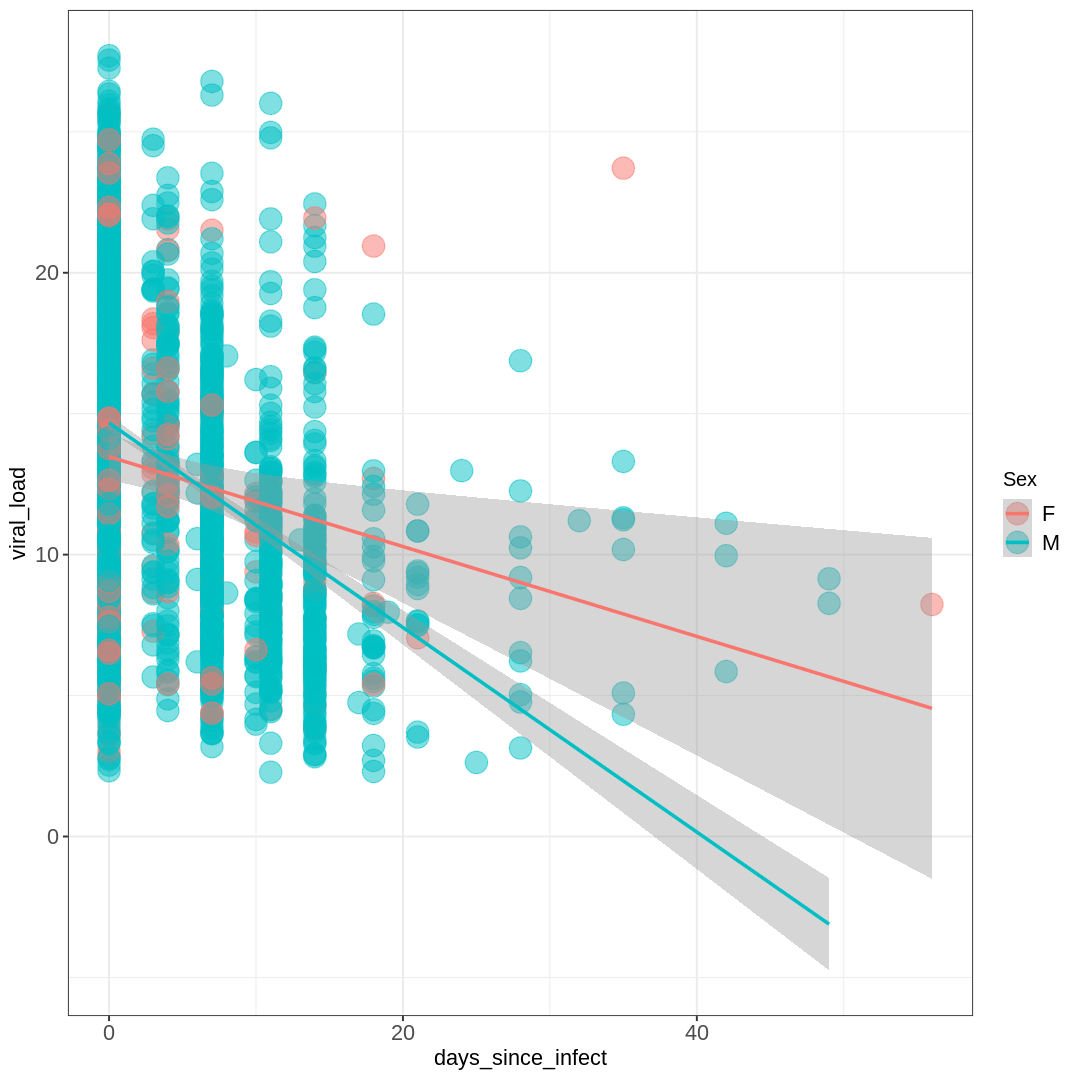

In [32]:
ggplot(symp_df2, aes(x=days_since_infect, y=viral_load, col=Sex)) +
geom_point(size=6, alpha=0.5) +
geom_smooth(method = "lm") + myTheme